In [1]:
import cv2
import numpy as np
import os
import sys
import argparse
from matplotlib import cm
import matplotlib.pyplot as plt
from skimage import io, feature, color, transform

In [2]:
def calculate_metric_angle(cur_pred, lines, ignore_pts, ransac_angle_thresh):
    cur_pred = cur_pred / cur_pred[-1]
    vp_dir = cur_pred[:2] - lines[:,0]
    lines_vp_dir = lines[:,1] - lines[:,0]
    mag = np.linalg.norm(vp_dir, axis=1) * np.linalg.norm(lines_vp_dir, axis=1)
    mag[mag == 0] = 1e-5
    cos_t = (vp_dir*lines_vp_dir).sum(axis=-1) / mag
    t = np.arccos(np.abs(cos_t))
    inliers = (t < ransac_angle_thresh * np.pi / 180)
    inliers[ignore_pts] = False
    return inliers, inliers.sum()

In [3]:
def run_line_ransac(lines, ransac_iter, ransac_angle_thresh, ignore_pts=None):
    largest_vote = 0
    largest_inliers = None
    largest_h = None
    if ignore_pts is None:
        ignore_pts = np.zeros((lines.shape[0])).astype('bool')
        lines_to_chose = np.arange(lines.shape[0])
    else:
        lines_to_chose = np.where(ignore_pts==0)[0]
    for iter_count in range(ransac_iter):
        idx1, idx2 = np.random.choice(lines_to_chose, 2, replace=False)
        l1 = np.cross(np.append(lines[idx1][1], 1), np.append(lines[idx1][0], 1))
        l2 = np.cross(np.append(lines[idx2][1], 1), np.append(lines[idx2][0], 1))

        current_h = np.cross(l1, l2)
        if current_h[-1] == 0:
            continue
        inliers, vote_count = calculate_metric_angle(current_h, lines, ignore_pts, ransac_angle_thresh)
        if vote_count > largest_vote:
            largest_vote = vote_count
            largest_h = current_h
            largest_inliers = inliers
    return largest_h, largest_inliers

In [4]:
def visualize_inliers(image, edges, lines, inlier_lines_list, colors, fig_name='detected_lines.png'):
    im = plt.imread("images/3.jpg")
    fig, ax = plt.subplots()

    for i in range(len(inlier_lines_list)):
        ax.imshow(edges * 0)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            ax.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])
    
    im = ax.imshow(im)
    plt.show()

In [5]:
image = io.imread("images/3.jpg")
edges = feature.canny(color.rgb2gray(image), sigma=5)
lines = transform.probabilistic_hough_line(edges, line_length=15, line_gap=7)
lines = np.asarray(lines)

# Predict 3 vanishing points and inlier
vp_1, inlier_1 = run_line_ransac(lines, 1000, 2) 
ignore_pts = inlier_1
vp_2, inlier_2 = run_line_ransac(lines, 1000, 2, ignore_pts=ignore_pts)
ignore_pts = np.logical_or(inlier_1, inlier_2)
vp_3, inlier_3 = run_line_ransac(lines, 1000, 2, ignore_pts=ignore_pts)
inlier_lines_list = [inlier_1, inlier_2, inlier_3]
vp_1 = vp_1 / vp_1[-1]
vp_2 = vp_2 / vp_2[-1]
vp_3 = vp_3 / vp_3[-1]
hypothesis_list = [vp_1, vp_2, vp_3]
viz_stuff = [image, edges, lines]
image, edges, lines = viz_stuff
vp_1, vp_2, vp_3 = hypothesis_list 
print("Vanishing point 1 coordinate:", vp_1)
print("Vanishing point 2 coordinate:", vp_2)
print("Vanishing point 3 coordinate:", vp_3)

<ipython-input-2-2312fac8ecc1>:8: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(np.abs(cos_t))


Vanishing point 1 coordinate: [ 1.16455e+04 -6.15676e+05  1.00000e+00]
Vanishing point 2 coordinate: [402. 298.   1.]
Vanishing point 3 coordinate: [4.01587629e+02 1.24976289e+03 1.00000000e+00]


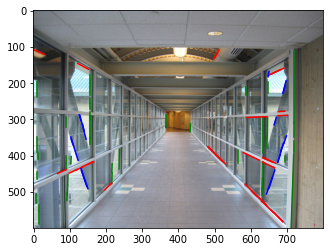

In [6]:
colors = ['g','r','b']
visualize_inliers(image, edges, lines, inlier_lines_list, colors, fig_name='123.png')

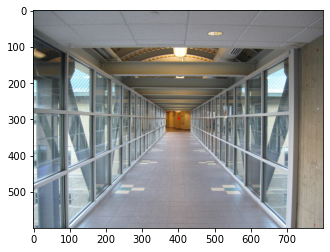

In [7]:
vpimg = cv2.imread('images/3.jpg')
vpimg = cv2.circle(vpimg, (int(vp_2[0]), int(vp_2[1])),  radius=0, color=(0, 0, 255), thickness=5)
vpimg = cv2.cvtColor(vpimg, cv2.COLOR_BGR2RGB)
plt.imshow(vpimg)

In [8]:
def select_correct_edge_points(part1_pts, part2_pts): # To select the most desired edge points in order to obtain the box layout
    part1_pts = np.array(part1_pts)
    part1_pts_copy = np.copy(part1_pts)
    part1_pts = part1_pts[np.argsort(part1_pts[:, 0])] # Sort edge points according to height
    lefttop = part1_pts[0] 
    leftbot = part1_pts[len(part1_pts) - 1] 
    part1_pts_copy = part1_pts_copy[np.argsort(part1_pts_copy[:, 1])] # Sort edge points according to width
    right_largest = part1_pts_copy[len(part1_pts_copy) - 1][1] 

    min_h = 600
    max_h = 0
    righttop = []
    rightbot = []
    for i in part1_pts_copy:
        if i[1] > right_largest - 10: # Buffer due to inconstiency in corner detection
            if i[0] < min_h:
                righttop = i
                min_h = i[0]
            if i[0] > max_h:
                rightbot = i
                max_h = i[0]
    rightmean = int(round((righttop[1] + rightbot[1]) / 2)) # Ensure points align 
    righttop[1] = rightmean
    rightbot[1] = rightmean
    
    part1_edge_pts = np.array([lefttop, leftbot, righttop, rightbot])
    
    
    
    part2_pts = np.array(part2_pts)
    part2_pts_copy = np.copy(part2_pts)
    part2_pts = part2_pts[np.argsort(part2_pts[:, 1])]
    part2_pts = part2_pts[np.argsort(part2_pts[:, 0], kind='stable')]

    righttop_2 = part2_pts[0]
    rightbot_2 = part2_pts[len(part2_pts) - 1]

    part2_pts_copy = part2_pts_copy[np.argsort(part2_pts_copy[:, 1])]
    length = part2_pts_copy[0][1]


    min_h = 600
    max_h = 0
    lefttop_2 = []
    leftbot_2 = []
    for i in part2_pts_copy:
        if i[1] < length + 10:
            if i[0] < min_h:
                lefttop_2 = i
                min_h = i[0]
            if i[0] > max_h:
                leftbot_2 = i
                max_h = i[0]

    leftmean = int(round((lefttop_2[1] + leftbot_2[1]) / 2))
    lefttop_2[1] = leftmean
    leftbot_2[1] = leftmean
    
    part2_edge_pts = np.array([lefttop_2, leftbot_2, righttop_2, rightbot_2])
    
    return part1_edge_pts, part2_edge_pts

Harris corner detector produced unsatisfactory corner detection results


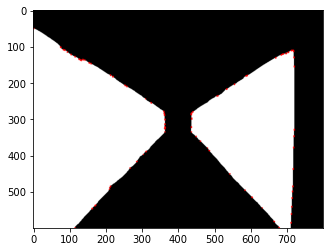

In [9]:
filename = 'images/mask_3.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()] = np.array([0 ,0, 255])
print("Harris corner detector produced unsatisfactory corner detection results")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Remove noise with median filter to produce more desired corner detection results


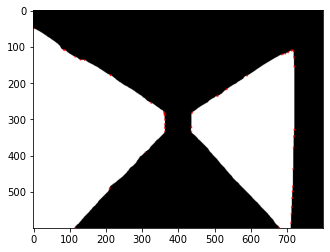

In [10]:
print("Remove noise with median filter to produce more desired corner detection results")
filename = 'images/mask_3.jpg'
img = cv2.imread(filename)
img_filtered = cv2.medianBlur(img, 5)
gray = cv2.cvtColor(img_filtered,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
img_filtered[dst>0.01*dst.max()] = np.array([0 ,0, 255])
plt.imshow(cv2.cvtColor(img_filtered,cv2.COLOR_BGR2RGB))

In [11]:
threshmid = 400 # To separate the two binary mask for the two side walls.

H,W,C = img_filtered.shape
corner_points = []
for i in range(H):
    for j in range(W):
        if np.array_equal(img_filtered[i][j], np.array([0,0,255])):
            corner_points.append([i,j])

corner_points = np.array(corner_points)
corner_points = corner_points[corner_points[:, 1].argsort()]

part1_pts = []
part2_pts = []

for i in corner_points:
    if i[1] > threshmid:
        part2_pts.append(i.tolist())
    else:
        part1_pts.append(i.tolist())
    
    
part1_edge_pts, part2_edge_pts = select_correct_edge_points(part1_pts, part2_pts) # Select 8 corner points for the box layout

Corner points after processing


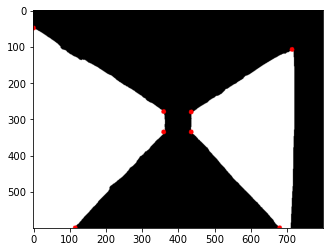

In [12]:
filename = 'images/mask_3.jpg'
img = cv2.imread(filename)
print("Corner points after processing")

for i in part1_edge_pts:
    img = cv2.circle(img, (i[1], i[0]),  radius=3, color=(255, 0, 0), thickness=5)
for i in part2_edge_pts:
    img = cv2.circle(img, (i[1], i[0]),  radius=3, color=(255, 0, 0), thickness=5)
    
plt.imshow(img)

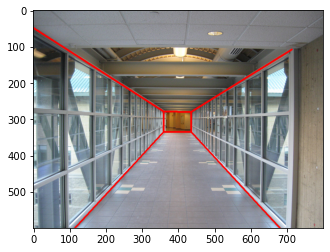

In [15]:
boximg = cv2.imread('images/3.jpg')

lefttop, leftbot, righttop, rightbot = part1_edge_pts
lefttop_2, leftbot_2, righttop_2, rightbot_2 = part2_edge_pts

cv2.line(boximg, (leftbot[1], leftbot[0]), (rightbot[1], rightbot[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (lefttop[1], lefttop[0]), (righttop[1], righttop[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (leftbot_2[1], leftbot_2[0]), (rightbot_2[1], rightbot_2[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (lefttop_2[1], lefttop_2[0]), (righttop_2[1], righttop_2[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (leftbot_2[1], leftbot_2[0]), (rightbot[1], rightbot[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (lefttop_2[1], lefttop_2[0]), (righttop[1], righttop[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (leftbot_2[1], leftbot_2[0]), (lefttop_2[1], lefttop_2[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (lefttop_2[1], lefttop_2[0]), (righttop[1], righttop[0]), (0, 0, 255), thickness=3, lineType=8)
cv2.line(boximg, (righttop[1], righttop[0]), (rightbot[1], rightbot[0]), (0, 0, 255), thickness=3, lineType=8)

boximg = cv2.cvtColor(boximg, cv2.COLOR_BGR2RGB)
plt.imshow(boximg)

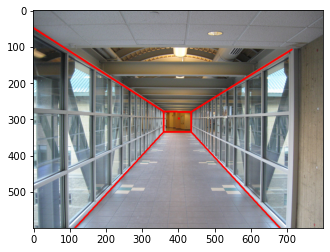

In [16]:
finalimg = boximg
finalimg = cv2.circle(finalimg, (int(vp_2[0]), int(vp_2[1])),  radius=0, color=(255, 0, 0), thickness=5)
plt.imshow(finalimg)